## Load the data

In [1]:
############## create sql table ################
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2

dbname = 'stack_exchange_db'
q_tbname = 'question_table'
a_tbname = 'answer_table'
username = 'dan-laptop'
import os
password = os.environ['PGRES_PASSWORD']

engine = create_engine('postgresql://%s:%s@localhost:5432/%s'%(username,password,dbname))

## Now access sql db from python
con = None
connect_str = "dbname='%s' user='%s' host='localhost' password='%s'"%(dbname,username,password)
con = psycopg2.connect(connect_str)
cur = con.cursor() #create cursor for communicating with sql

In [2]:
import pandas as pd
################# make query ########################
sql_query = """
    SELECT answer_table.word_vec, answer_table.score 
    FROM answer_table
    INNER JOIN question_table
        on answer_table.q_id = question_table.q_id
        and question_table.view_count > 50;
"""
question_df = pd.read_sql_query(sql_query,con)
question_df.head()

,word_vec,score
0,"found,quick,googl,search,look,differ,express,s...",2
1,"quit,wari,classif,like,especi,attempt,make,hie...",1
2,"ye,almost,express,someth,evalu,valu,hand,state...",5
3,"sqlite3,look,file,path,except,locat",0
4,"ye,occur,still,local,will,delet,instal,db",0


In [3]:
len(question_df)

410757

In [4]:
import numpy as np
threshold = 2

y = question_df['score'].copy()
y[y<threshold] = 0
y[y>0] = 1
print(np.mean(y))

0.1797169616099056


In [5]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib

In [6]:
lg = joblib.load('../Data_and_Models/lin_reg_model.pkl')
vectorizer = joblib.load('../Data_and_Models/count_vec.pkl')
tf_transformer = joblib.load('../Data_and_Models/tfidf_tansformer.pkl')

In [7]:
 for i,keys in enumerate(vectorizer.vocabulary_):
        print(keys)
        if i == 20:break

tp_d
blist
vsnrgf
epilogu
mahota
randomgeneratednumb
from_somewher
plist2
colordescriptor
obvious
libxlst
enumdescriptor
showimag
150px
winhttpj
roundtim
amour
dotcomli
lincoln
halston
nitti


In [8]:
lg.coef_

array([[  4.16330395e-03,   1.66120639e-03,  -2.48881725e-04, ...,
         -5.05034061e-06,  -5.05034061e-06,  -8.74546346e-04]])

In [9]:
num_2_find = 50
#find_best_predictor = np.argmax(abs(lg.coef_))
find_best_predictors = np.argsort(abs(lg.coef_))
find_best_predictors = find_best_predictors[0][-num_2_find:]
print(find_best_predictors)
print(lg.coef_[0][find_best_predictors])

[235921 243825 171283 274957  98873 152245 106133  92730 270122 147281
 104847 155309 180835 208137 115978 151990 296386 144445 161806  38425
 164342  38830 236285 220920 147384 108069  57055 151500  82563 119723
 138653 200462 158333  64402 308875 258086 199699 204197 275573 192866
 295514 167306  87642 256112 225218  84761 244418 304696 200826 143273]
[ 0.71236468  0.71994661  0.72388295  0.7252863   0.72740499  0.73102579
  0.73359255  0.74963009  0.78683369  0.80076715  0.82739308  0.83295461
  0.84142221  0.84377613  0.84871779  0.84934852  0.86046318  0.86256898
  0.88310889  0.89801528  0.90057709  0.91243979  0.93345908  0.93483575
  0.93557281  0.93622299  0.95604727  0.96689479  0.97057997  0.97413633
  1.0010351   1.0085238   1.09318814  1.09772611  1.101603    1.10452944
  1.15723265  1.17966621  1.2803406   1.38614107  1.47685496  1.50472298
  1.55829247  1.59310077  1.61643832  1.68162025  1.76724603  1.80865612
  1.97485199  2.61036978]


In [11]:
word_vect = []
coef_vect = []

for word, place in vectorizer.vocabulary_.items():
    if place in find_best_predictors:
        #print(place)
        word_vect.append(word)
        coef_vect.append(lg.coef_[0][place])

In [14]:
order = np.argsort(abs(np.array(coef_vect)))

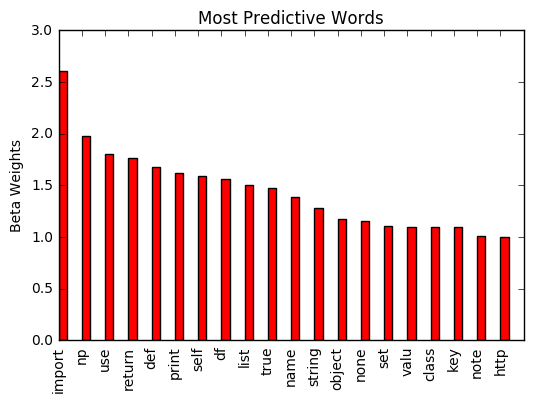

In [35]:
import matplotlib.pyplot as plt

width = 0.35       # the width of the bars

ind = np.arange(20)  # the x locations for the groups

data = np.array(coef_vect)[order]
data_label = [word_vect[x] for x in order]
#data = 

fig, ax = plt.subplots()
rects1 = ax.bar(ind, data[-20:][::-1], width, color='r')

# add some text for labels, title and axes ticks
ax.set_ylabel('Beta Weights')
ax.set_title('Most Predictive Words')
ax.set_xticks(ind + width / 2)
plt.xticks(ind, data_label[-20:][::-1], rotation='vertical')
#ax.set_xticklabels(data_label[-20:]);
plt.show()

In [18]:
order

array([ 3, 11, 19, 34, 41, 23, 18, 17, 12, 48,  8,  0, 35, 31, 28, 49, 38,
       32, 33,  7, 45, 46, 29,  9,  5, 42,  2, 37, 43, 25, 24, 10, 21, 20,
       13, 22, 44, 15, 30, 36, 39, 26,  4, 40, 47,  1, 16,  6, 27, 14])

In [21]:
word_vect[1]

'def'

In [12]:
#vectorizer = CountVectorizer(lowercase=False,ngram_range=(1,2))

#vectorizer = CountVectorizer(lowercase=False)
X_count = vectorizer.fit_transform(question_df['word_vec'].values)

#tf_transformer = TfidfTransformer()
X_tf = tf_transformer.fit_transform(X_count)

X_train, X_test, y_train, y_test = train_test_split(X_tf, y, test_size=0.1)

In [10]:
lg = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3,n_iter=1,verbose=0,class_weight='balanced')

from time import time

t0 = time()
epochs=5
for i in range(epochs):
    lg.fit(X_train,y_train)
    if (i+1)%1==0: print('Epoch %s. Cross Validated Acc:%0.2f'%(i+1,lg.score(X_test,y_test)))

print("done in %0.3fs." % (time() - t0))

Epoch 1. Cross Validated Acc:0.73
Epoch 2. Cross Validated Acc:0.74
Epoch 3. Cross Validated Acc:0.73
Epoch 4. Cross Validated Acc:0.74
Epoch 5. Cross Validated Acc:0.73
done in 1.977s.


In [11]:
from sklearn.externals import joblib

joblib.dump(lg,'../Data_and_Models/forest_model.pkl') 
#joblib.dump(vectorizer,'../Data_and_Models/count_vec.pkl')
#joblib.dump(tf_transformer,'../Data_and_Models/tfidf_tansformer.pkl')

['../Data_and_Models/tfidf_tansformer.pkl']

In [7]:
X_count = vectorizer.transform(question_df['word_vec'].values)
X_tf = tf_transformer.transform(X_count)

X_train, X_test, y_train, y_test = train_test_split(X_tf, y, test_size=0.1)

In [55]:
from sklearn.ensemble import RandomForestClassifier

lg = RandomForestClassifier(n_estimators=50,class_weight='balanced')

lg.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [56]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
#%matplotlib inline

def create_ROC_plt(lg,X_test,y_test,lw=2):
    try:
        y_score = lg.decision_function(X_test)
    except:
        y_score = lg.predict_proba(X_test)[:,1]
        
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',\
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")

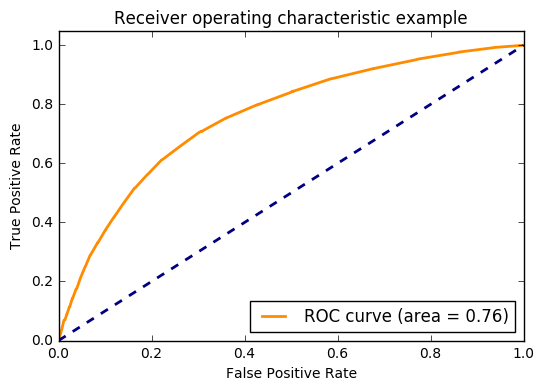

In [57]:
create_ROC_plt(lg,X_test,y_test)
plt.show()

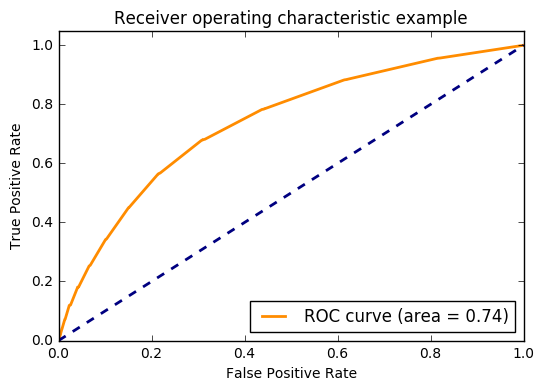

In [54]:
create_ROC_plt(lg,X_test,y_test)
plt.show()

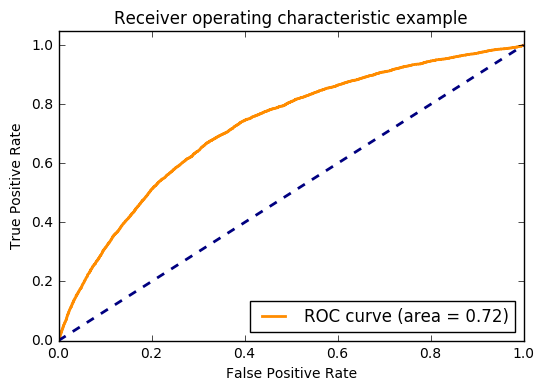

In [10]:
plt.show()

In [50]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 1.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

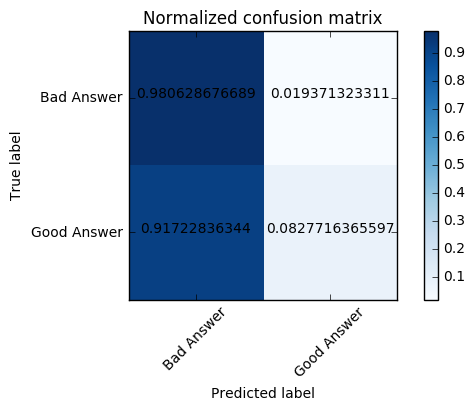

In [51]:
y_pred = lg.predict(X_test)

from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Bad Answer','Good Answer'], normalize=True,\
                      title='Normalized confusion matrix')
plt.show()

In [29]:
from sklearn import naive_bayes
nb = naive_bayes.MultinomialNB()

nb.fit(X_train,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

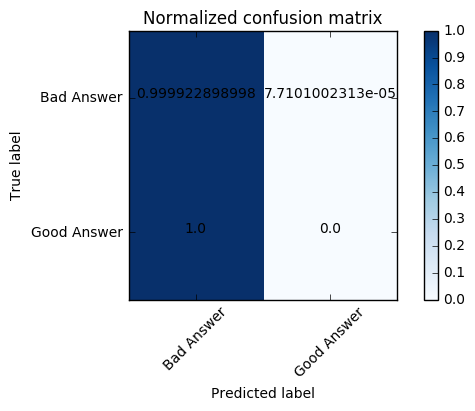

In [33]:
y_pred = nb.predict(X_test)

from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Bad Answer','Good Answer'], normalize=True,\
                      title='Normalized confusion matrix')

## Below is the grid search i did to find the values above

In [188]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(question_df['word_vec'].values, y, test_size=0.1)

In [189]:
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

text_clf = Pipeline([('vect', CountVectorizer(lowercase=False)),
                      ('tfidf', TfidfTransformer()),
                      ('clf', SGDClassifier(loss='hinge', penalty='l2',
                                            alpha=1e-3, n_iter=5, class_weight='balanced')),
                     ])

if this model continues to work look at the best parameters, recreate it outside the pipeline, save it, and see if you can train it further with more gradient descent. Also see how well a naive bayes can do. 

If all this works, then do your resume, edit the plots from last time, and make presentation. Don't use plot 3. Just report the percent of good answers. Remake the final plot but as views against answer score to show why this is better as a classification problem.

After all this, get started on that webapp!!!

In [190]:
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
               'tfidf__use_idf': (True, False),
               'clf__alpha': (1e-2, 1e-3),
             }

from sklearn.grid_search import GridSearchCV

t0 = time()
rs_clf = GridSearchCV(text_clf, parameters, n_jobs=1)
rs_clf.fit(X_train, y_train)
print("done in %0.3fs." % (time() - t0))

done in 1227.262s.


In [191]:
rs_clf.best_score_

0.77050544121672793

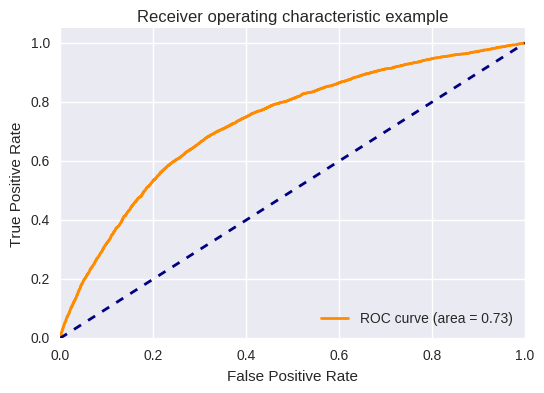

In [195]:
create_ROC_plt(rs_clf,X_test,y_test)

In [197]:
y_pred = rs_clf.predict(X_test)

In [200]:
print(rs_clf.score(X_test,y_test))

0.777148524989


Confusion matrix, without normalization
[[21889  3953]
 [ 3012  2400]]
Normalized confusion matrix
[[ 0.85  0.15]
 [ 0.56  0.44]]


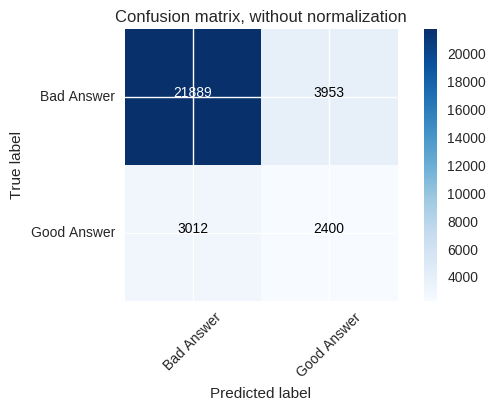

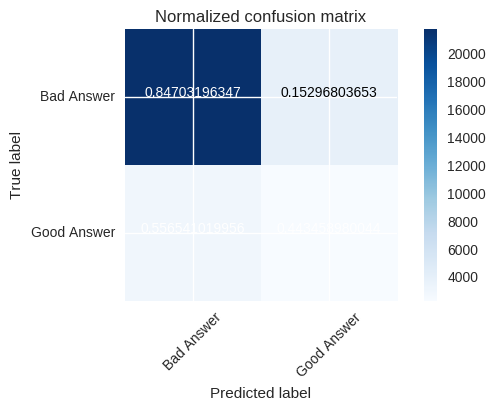

In [201]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Bad Answer','Good Answer'],\
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Bad Answer','Good Answer'], normalize=True,\
                      title='Normalized confusion matrix')

In [202]:
rs_clf.best_params_

{'clf__alpha': 0.001, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 2)}

In [ ]:
########## Close Connections ##############
cur.close()
con.close()